# Customer Churn Prediction with Random Forest
 
 Questo progetto utilizza un modello di machine learning basato su Random Forest per prevedere il **churn dei clienti** (abbandono) nel settore delle telecomunicazioni.
 Il dataset utilizzato è il [Telco Customer Churn Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) disponibile su Kaggle.


### 1. Import delle librerie necessarie

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV


### 2. Caricamento del dataset


In [62]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 3. Esplorazione iniziale dei dati

In [63]:
print("\nInformazioni generali sul dataset:")
df.info()

print("\nValori nulli per colonna:")
print(df.isnull().sum())

# La colonna 'TotalCharges' contiene alcuni valori vuoti: li rimuoviamo
# Convertiamo la colonna in numerico (attualmente è oggetto)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()


Informazioni generali sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperl

### 4. Analisi Esplorativa (EDA)

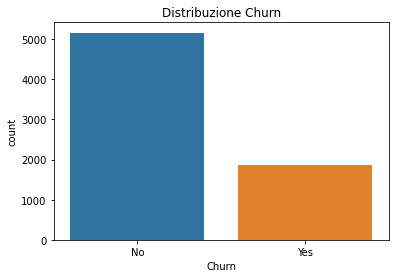

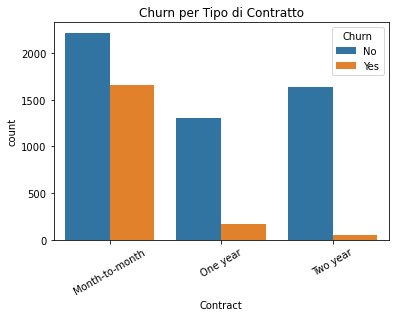

In [64]:
# Distribuzione della variabile target (Churn)
sns.countplot(data=df, x='Churn')
plt.title('Distribuzione Churn')
plt.show()

# Churn per tipo di contratto
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Churn per Tipo di Contratto')
plt.xticks(rotation=30)
plt.show()

### 5. Preparazione dei dati

Distribuzione originale: {0: 4130, 1: 1495}
Distribuzione dopo SMOTE: {0: 4130, 1: 2478}


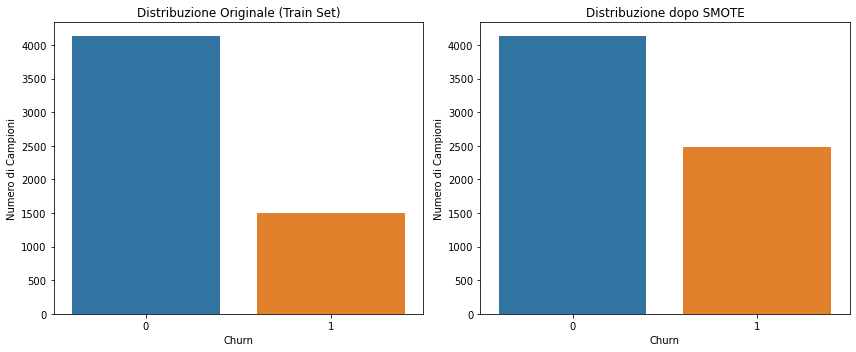

In [65]:
# Rimuoviamo colonne non utili o ridondanti
# CustomerID non contiene informazione predittiva
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)


# Codifichiamo le variabili categoriche
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == object:
        df[column] = le.fit_transform(df[column])

# Separiamo feature e target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Divisione in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------------------------------------
# Bilanciamento del training set con SMOTE
# ----------------------------------------------------------
# Applichiamo SMOTE solo al set di training per evitare data leakage
sm = SMOTE(sampling_strategy=0.6, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Distribuzione originale:", y_train.value_counts().to_dict())
print("Distribuzione dopo SMOTE:", y_train_res.value_counts().to_dict())

# Visualizzazione della distribuzione prima e dopo SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Prima di SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Distribuzione Originale (Train Set)')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Numero di Campioni')

# Dopo SMOTE
sns.countplot(x=y_train_res, ax=axes[1])
axes[1].set_title('Distribuzione dopo SMOTE')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Numero di Campioni')

plt.tight_layout()
plt.show()



### 6. Addestramento modello Random Forest

In [66]:

# Creazione e addestramento del classificatore
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,                # limita la profondità
    min_samples_split=20,       # evita rami troppo piccoli
    min_samples_leaf=10,        # evita foglie con 1-2 elementi
    random_state=42
)
rf_model.fit(X_train_res, y_train_res)


RandomForestClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

### 7. Valutazione del modello


Accuracy: 0.7732764747690121

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1033
           1       0.57      0.61      0.59       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.72      1407
weighted avg       0.78      0.77      0.78      1407



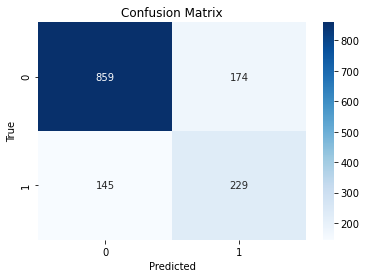

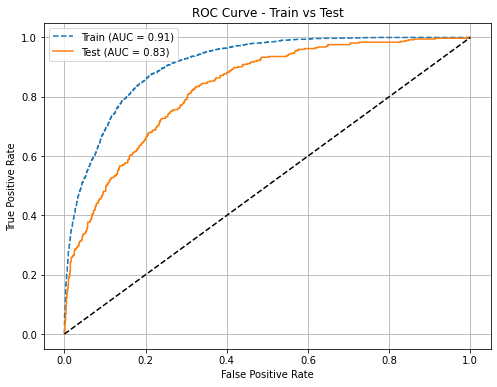

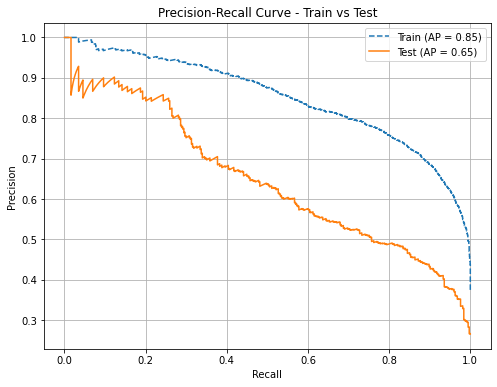


--- Diagnosi automatica del modello ---
✅ Buon modello: non sono evidenti segni di overfitting o underfitting.
ROC AUC Train = 0.91, Test = 0.83
Avg Precision Train = 0.85, Test = 0.65


In [67]:

y_pred = rf_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Probabilità predette su TEST set
y_prob_test = rf_model.predict_proba(X_test)[:, 1]

# Probabilità predette su TRAIN set (bilanciato con SMOTE)
y_prob_train = rf_model.predict_proba(X_train_res)[:, 1]

# -------------------------------
# ROC Curve
# -------------------------------
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {roc_auc_train:.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Train vs Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# -------------------------------
# Precision-Recall Curve
# -------------------------------
precision_train, recall_train, _ = precision_recall_curve(y_train_res, y_prob_train)
avg_precision_train = average_precision_score(y_train_res, y_prob_train)

precision_test, recall_test, _ = precision_recall_curve(y_test, y_prob_test)
avg_precision_test = average_precision_score(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label=f'Train (AP = {avg_precision_train:.2f})', linestyle='--')
plt.plot(recall_test, precision_test, label=f'Test (AP = {avg_precision_test:.2f})')
plt.title('Precision-Recall Curve - Train vs Test')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()


# Diagnosi automatica basata su soglie empiriche
print("\n--- Diagnosi automatica del modello ---")
roc_gap = roc_auc_train - roc_auc_test
pr_gap = avg_precision_train - avg_precision_test

# Casi di overfitting
if roc_gap > 0.1 and avg_precision_test < 0.8:
    print("⚠️ Possibile OVERFITTING: il modello ha performance molto migliori sul training rispetto al test.")
    print(f"ROC AUC Train = {roc_auc_train:.2f}, Test = {roc_auc_test:.2f}")
    print(f"Avg Precision Train = {avg_precision_train:.2f}, Test = {avg_precision_test:.2f}")

# Casi di underfitting
elif roc_auc_train < 0.7 and roc_auc_test < 0.7:
    print("⚠️ Possibile UNDERFITTING: il modello ha performance basse su entrambi i set.")
    print(f"ROC AUC Train = {roc_auc_train:.2f}, Test = {roc_auc_test:.2f}")
    print(f"Avg Precision Train = {avg_precision_train:.2f}, Test = {avg_precision_test:.2f}")

# Modello bilanciato
else:
    print("✅ Buon modello: non sono evidenti segni di overfitting o underfitting.")
    print(f"ROC AUC Train = {roc_auc_train:.2f}, Test = {roc_auc_test:.2f}")
    print(f"Avg Precision Train = {avg_precision_train:.2f}, Test = {avg_precision_test:.2f}")



### 8. Feature Importance

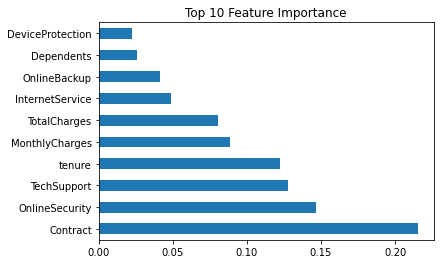

In [68]:

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importance')
plt.show()




### 9. Conclusioni aziendali
Il modello ha identificato correttamente diversi clienti a rischio di abbandono.
Le variabili più importanti sono:

1. Contract (Tipo di contratto)
🔑 Impatto: è la feature più rilevante.
📈 Interpretazione: i clienti con contratti mensili sono molto più propensi ad abbandonare rispetto a quelli con contratti annuali o biennali. Questo perché contratti più lunghi implicano maggiore fidelizzazione e penalità per la disdetta.

2. OnlineSecurity (Servizio di sicurezza online)
🔐 Impatto: tra le prime feature più influenti.
📉 Interpretazione: i clienti senza protezione online (es. antivirus incluso nell’abbonamento) tendono ad abbandonare di più. Avere questo servizio sembra aumentare la percezione di valore e ridurre il churn.

3. TechSupport (Supporto tecnico)
🛠️ Impatto: importante nella classificazione.
📊 Interpretazione: i clienti senza supporto tecnico attivo risultano meno fidelizzati. Questo suggerisce che avere accesso a un canale di assistenza migliora l’esperienza e riduce il rischio di abbandono.

4. tenure (Anzianità del cliente in mesi)
📅 Impatto: rilevante ma meno delle altre.
📊 Interpretazione: i nuovi clienti (bassa anzianità) sono più a rischio di abbandono, mentre quelli più “vecchi” tendono a restare. Ciò conferma che i primi mesi sono critici per la fidelizzazione.

L'uso di SMOTE ha permesso di migliorare la sensibilità del modello verso i clienti che abbandonano.
Possiamo usare questo modello per supportare strategie di fidelizzazione mirate, ad esempio:
1. proporre sconti o upgrade a chi ha contratto mensile,
2. offrire servizi di sicurezza gratuiti nei primi mesi,
3. garantire supporto tecnico proattivo ai nuovi clienti.